# Load Packages

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC
from ISLP import load_data, confusion_table
from ISLP.svm import plot as plot_svm

- We use `RocCurveDisplay.from_estimator()` to produce many ROC plots, better using a shorthand `roc_curve`.

In [2]:
roc_curve = RocCurveDisplay.from_estimator # shorthand

# Support Vector Classifier
- We use `SupportVectorClassifier()` (`SVC`) from `sklearn.svm` to fit a support vector classifier.
- We use the `C` parameter to specify the cost of a violation to the margin.
    - A small `C` value allows more violations to the margin.
    - A large `C` value allows fewer violations to the margin.
    - In other words, a small `C` value allows a wider margin. Then many support vectors (points) will be on the margin or in the wrong side of the margin. And vice versa.
- We use the `kernel` parameter to specify the kernel type.
    - `linear` kernel is a linear hyperplane.
    - `rbf` kernel is a radial basis function.
## Two-dimensional example
### a. Clear separation

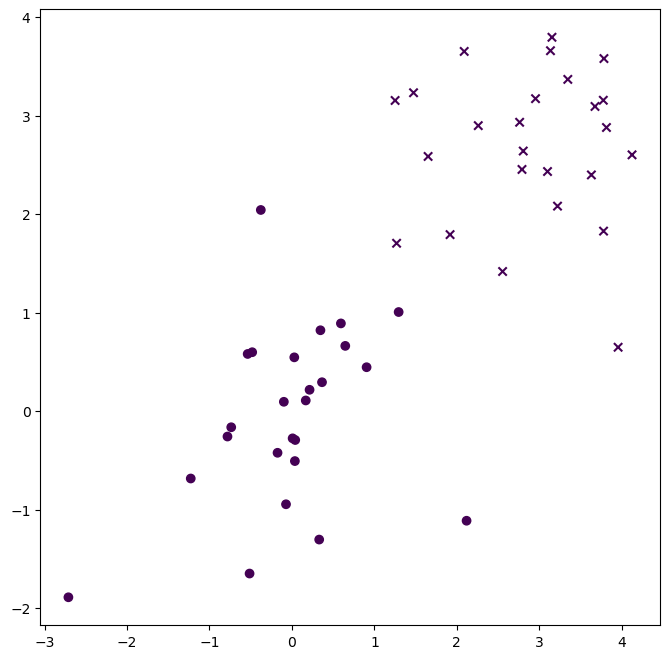

In [3]:
# Generate data
rng = np.random.default_rng(1)
# Create a 2D dataset with shape (50, 2)
X = rng.standard_normal((50, 2))
# Create a vector of 50 elements with the first 25 being -1 and the last 25 being 1
y = np.array([-1]*25+[1]*25)
# Select the last 25 rows of X and add 2.9
X[y==1] += 2.9;
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:25,0], X[:25,1], c=y[:25], marker='o')
ax.scatter(X[25:,0], X[25:,1], c=y[25:], marker='x');

In [4]:
SVM_clearLarge = SVC(C=1e5, kernel='linear').fit(X, y)
y_hat_clearLarge = SVM_clearLarge.predict(X)
confusion_table(y_hat_clearLarge, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


- We fit the support vector classifier and plot the resulting hyperplane:
    - using a very large value of `C` so that no observations are misclassified.

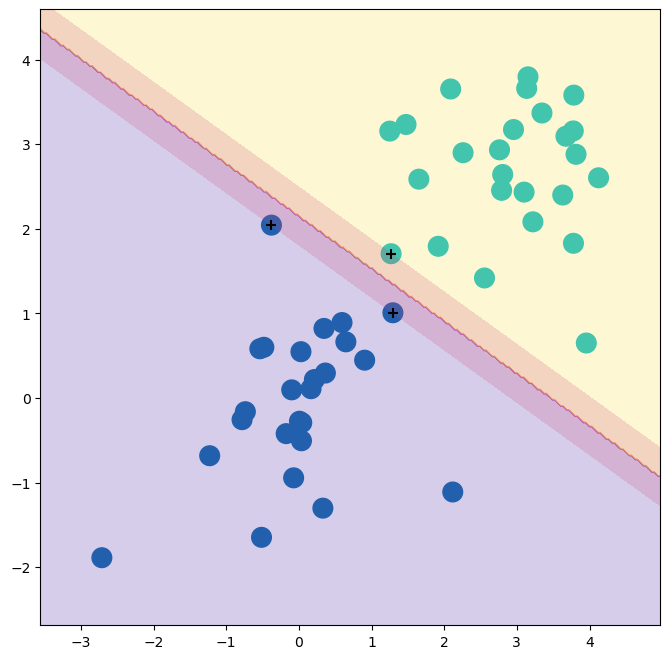

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X, y, SVM_clearLarge, ax=ax)

- Indeed no training errors were made and only three support vectors were used.
- In fact, the large value of `C` also means that these three support points are *on the margin*, and define it.
- One may wonder how good the classifier could be on test data that depends on only three data points!
- We now try a smaller value of `C`.

In [6]:
SVM_clearSmall = SVC(C=0.1, kernel='linear').fit(X, y)
y_hat_clearSmall = SVM_clearSmall.predict(X)
confusion_table(y_hat_clearSmall, y)

Truth,-1,1
Predicted,,
-1,25,0
1,0,25


- Using `C=0.1`, we again do not misclassify any training observations
    - But we obtain a much wider margin and make use of twelve support vectors.
    - These jointly define the orientation of the decision boundary, and since there are more of them, it is more stable.
- It seems possible that this model will perform better on test
data than the model with `C=1e5` (and indeed, a simple xperiment with a large test set would bear this out).

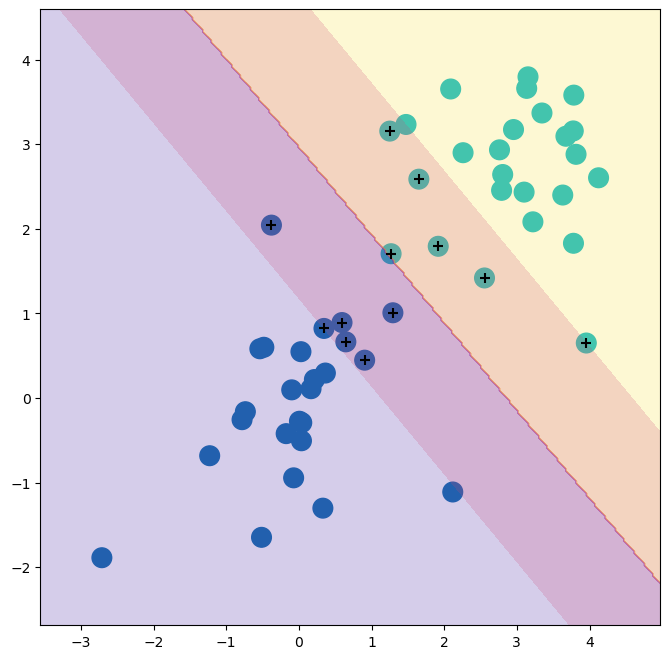

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X, y, SVM_clearSmall, ax=ax)

### b. Unclear Separation

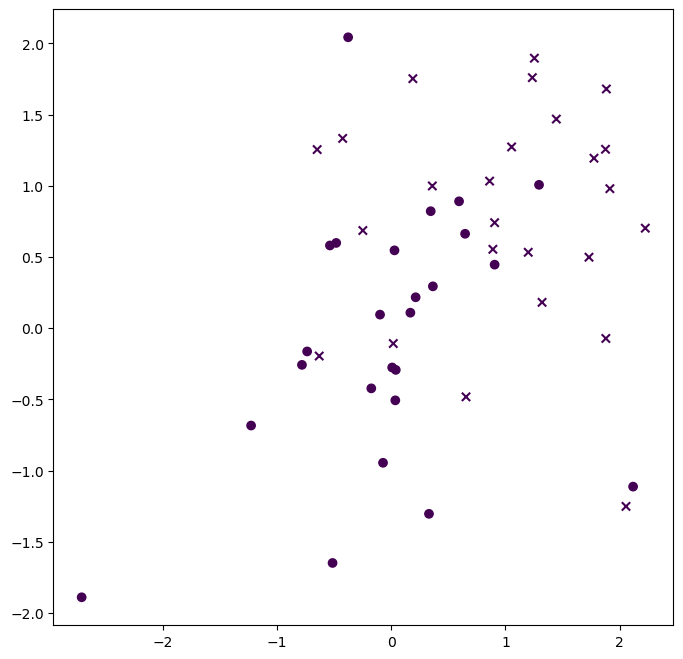

In [8]:
# Generate data
rng = np.random.default_rng(1)
# Create a 2D dataset with shape (50, 2)
X = rng.standard_normal((50, 2))
# Create a vector of 50 elements with the first 25 being -1 and the last 25 being 1
y = np.array([-1]*25+[1]*25)
# Select the last 25 rows of X and add 1
X[y==1] += 1
# Create a scatter plot of the data
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:25,0], X[:25,1], c=y[:25], marker='o')
ax.scatter(X[25:,0], X[25:,1], c=y[25:], marker='x');

- We use `kernel='linear'` to fit a linear line as the decision boundary.

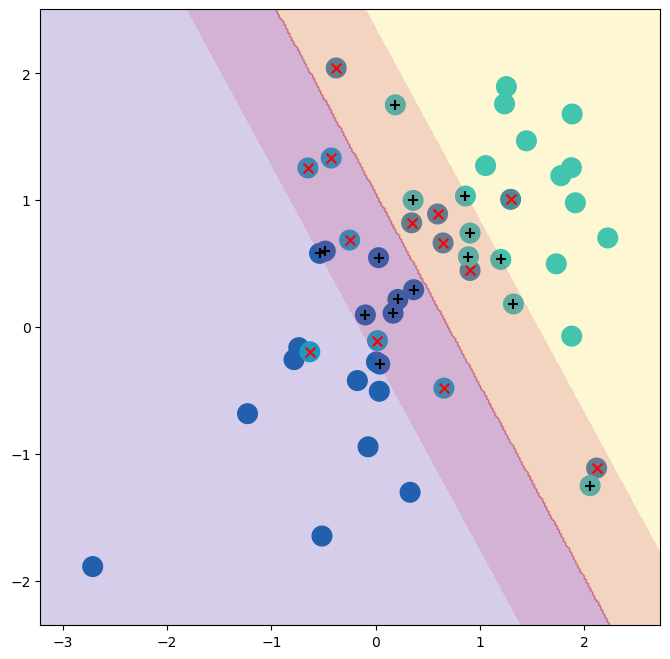

In [9]:
SVM_unclearLarge = SVC(C=10, kernel='linear').fit(X, y)
# Plot the decision boundary
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X, y, SVM_unclearLarge, ax=ax)

- The support vectors are marked with `+` and stored in `svc.support_vectors_`.
- The violating points are marked with `x`
- The `svm_linear.decision_function()` method computes the distance of each sample in X to the decision boundary, with positive values indicating one side and negative values the other.
- The `svm_linear.support_` attribute provides the indices of the support vectors in the training set.

In [10]:
# Show the support vectors
print('First 3 support vectors:\n', SVM_unclearLarge.support_vectors_[:3])
# Show the distance of the samples to the decision boundary
print('First 3 decision function values:\n', SVM_unclearLarge.decision_function(X)[:3])

First 3 support vectors:
 [[ 0.34558419  0.82161814]
 [ 0.90535587  0.44637457]
 [-0.53695324  0.5811181 ]]
First 3 decision function values:
 [ 0.22101667 -1.44022758  0.58740667]


- We use a smaller value of `C` (cost parameter) to allow more violations to the margin.

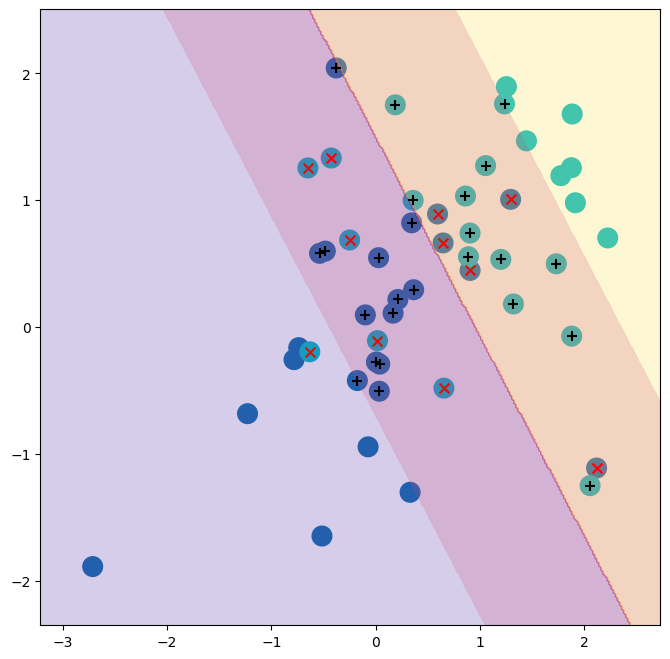

In [11]:
SVM_unclearSmall = SVC(C=0.1, kernel='linear').fit(X, y)
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X, y, SVM_unclearSmall, ax=ax)

- We obtain a larger number of support vectors with a smaller value of the cost parameter, because the margin is wider.
- We can extract the coefficients of the linear decision boundary as follows:

In [12]:
SVM_unclearLarge.coef_

array([[1.17303943, 0.77348227]])

- We can use standard tools to tune the cost parameter `C` because SVM is an estimator in `sklearn`.

In [13]:
# Define 5-fold cross-validation
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
# Perform 5-fold cross-validation
grid_unclearLarge = skm.GridSearchCV(SVM_unclearLarge,
                        {'C':[0.001,0.01,0.1,1,5,10,100]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid_unclearLarge.fit(X, y)
# Show the best parameter
grid_unclearLarge.best_params_

{'C': 1}

- We show the cross-validation error for each value of `C` in the grid.

In [14]:
pd.DataFrame( {'C':[0.001,0.01,0.1,1,5,10,100], 
               'Mean test score':grid_unclearLarge.cv_results_[('mean_test_score')]})

,C,Mean test score
0,0.001,0.46
1,0.010,0.46
2,0.100,0.72
3,1.000,0.74
4,5.000,0.74
5,10.000,0.74
6,100.000,0.74


- The result shows that the cross-validation accuracy is 0.74 for `C=1` and above.
- We get the best estimator with `grid.best_estimator_` and use it for the generated test data set.

In [15]:
# Generate test data
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1]*10+[1]*10)
X_test[y_test==1] += 1
# Get the best estimator
bestgrid_unclearLarge = grid_unclearLarge.best_estimator_
# Predict the test data
y_test_hat_unclearLarge = bestgrid_unclearLarge.predict(X_test)
# Create a confusion table
confusion_table(y_test_hat_unclearLarge, y_test)

Truth,-1,1
Predicted,,
-1,8,4
1,2,6


- With `C=1`, the accuracy is 14/20 = 0.7.
- We try `C=0.01`. The accuracy is 12/20 = 0.6.

In [16]:
y_test_hat_unclearSmall = SVM_unclearSmall.predict(X_test)
confusion_table(y_test_hat_unclearSmall, y_test)

Truth,-1,1
Predicted,,
-1,8,6
1,2,4


# Support Vector Machine
- We use `SupportVectorMachine()` (`SVC`) from `sklearn.svm` to fit a support vector machine.
- We use `kernel="poly"` to fit a polynomial kernel.
    - The `degree` parameter specifies the degree of the polynomial kernel.
- We use `kernel="rbf"` to fit a radial basis function kernel.
    - The `gamma` parameter specifies the kernel coefficient for `rbf`.

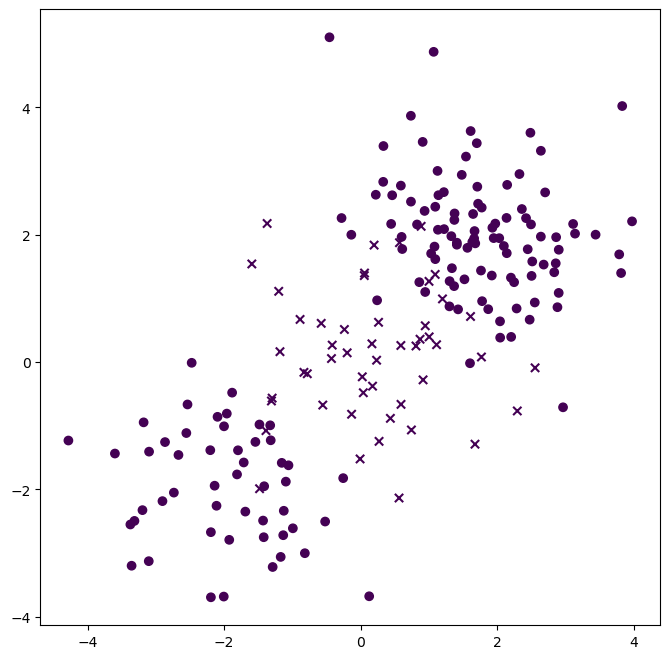

In [17]:
# Generate non-linear data
# Create a 2D dataset with shape (200, 2)
X = rng.standard_normal((200, 2))
# Select the first 100 rows of X and add 2 to each element
X[:100] += 2
# Select the rows from 100 to 150 of X and subtract 2 from each element
X[100:150] -= 2
# Create a vector of 200 elements with the first 150 being 1 and the last 50 being 2
y = np.array([1]*150+[2]*50)
# Create a scatter plot of the data
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:150,0], X[:150,1], c=y[:150], marker='o')
ax.scatter(X[150:,0], X[150:,1], c=y[150:], marker='x');

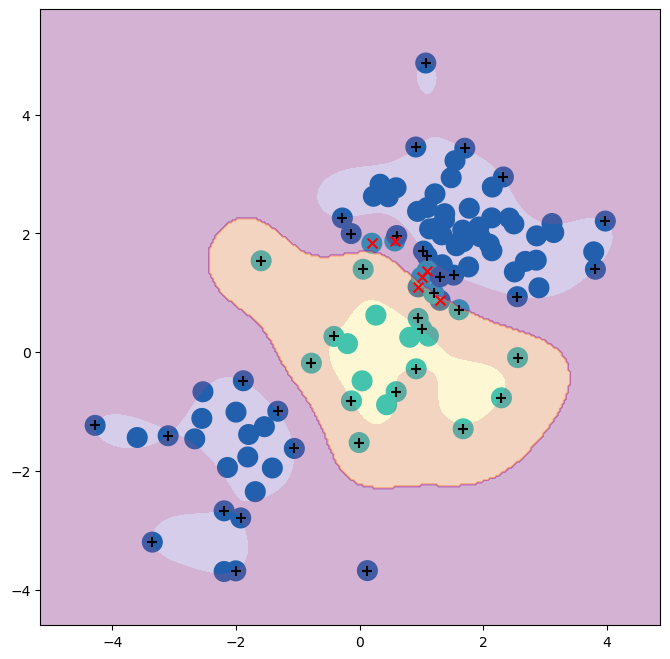

In [18]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = skm.train_test_split(X, y,
                                 test_size=0.5,random_state=0)
# Fit a radical basis function SVM
SVM_rbf1 = SVC(kernel="rbf", gamma=1, C=1).fit(X_train, y_train)
# Plot the decision boundary
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X_train, y_train, SVM_rbf1, ax=ax)

- The plot shows that the resulting SVM has a decidedly non-linear boundary.
- The plot shows that there are some training errors.
- We increase the value of `C` to reduce the number of training errors. But it can lead to overfitting if we increase `C` too much. The more irregular the boundary, the more likely overfitting will occur.

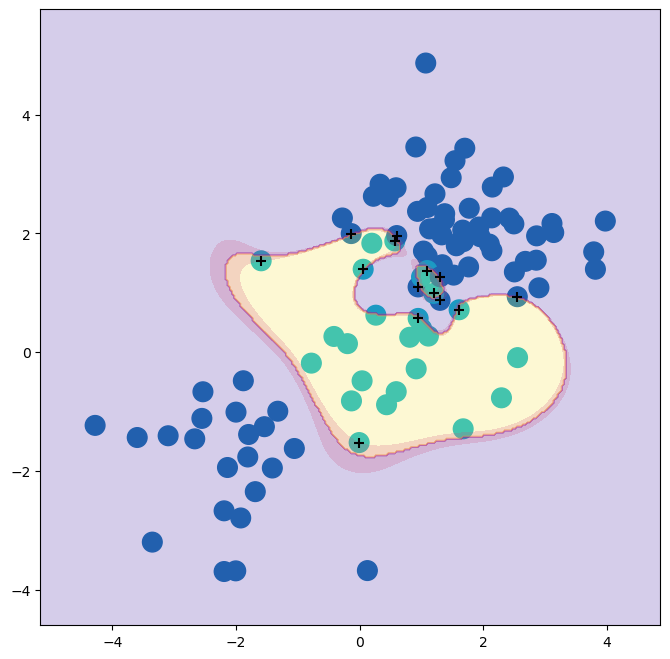

In [19]:
SVM_rbf1e5 = SVC(kernel="rbf", gamma=1, C=1e5).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X_train, y_train, SVM_rbf1e5, ax=ax)

- We use `skm.GridSearchCV()` to tune the hyperparameters `C` and `gamma` for the radial basis function kernel.

We can perform cross-validation using `skm.GridSearchCV()`  to select the
best choice of $\gamma$ and `C` for an SVM with a radial
kernel:

In [20]:
# Set 5-fold cross-validation
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
# Perform 5-fold cross-validation
gridSVM_rbf1e5 = skm.GridSearchCV(SVM_rbf1e5,
                        {'C':[0.1,1,10,100,1000],
                         'gamma':[0.5,1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
gridSVM_rbf1e5.fit(X_train, y_train)
# Show the best parameters
gridSVM_rbf1e5.best_params_

{'C': 1, 'gamma': 0.5}

- The best choice of parameters under five-fold CV is achieved at `C=1`and `gamma=0.5`, though several other values also achieve the same value.

Truth,1,2
Predicted,,
1,69,6
2,6,19


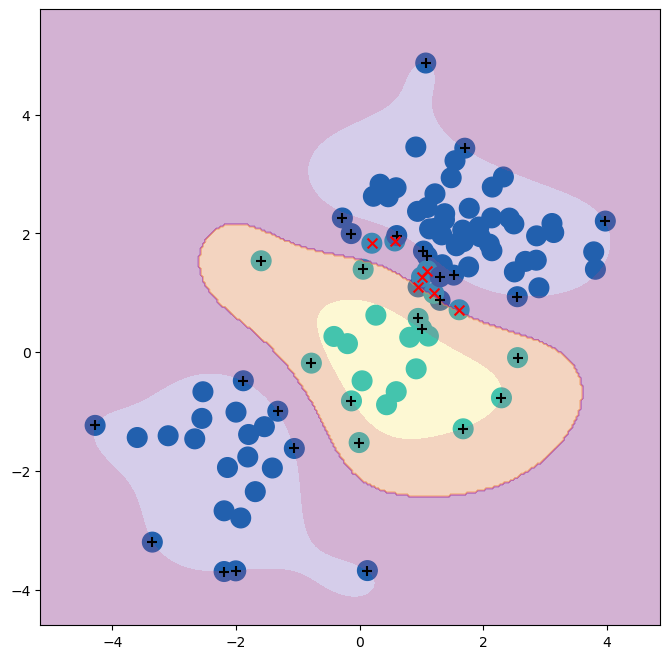

In [26]:
# Get the best estimator
bestgrid_rbf05 = gridSVM_rbf1e5.best_estimator_
# Plot the decision boundary of the best estimator
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X_train, y_train, bestgrid_rbf05, ax=ax)
# Predict the test data
y_hat_test_rbf05 = bestgrid_rbf05.predict(X_test)
# Create a confusion table
confusion_table(y_hat_test_rbf05, y_test)

- With these parameters, $12/100=12\%$ of test observations are misclassified by this SVM.

# ROC Curves
- We use `ROCCurveDisplay.from_estimator()` (`roc_curve()`) to produce a ROC plot.
    - The first argument is a fitted estimator.
    - The second and third arguments are the model matrix `X` and the labels `y`.
    - The `name` argument is used in the legend.
    - The `color` argument is used for the color of the line.
- Begin theory: The ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) for the different possible cutpoints of a diagnostic test. The area under the curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups (diseased/normal).
- SVMs and support vector classifiers output class labels for each observation. However, it is also possible to obtain *fitted values* for each observation, which are the numerical scores used to obtain the class labels.
    - For instance, in the case of a support vector classifier, the fitted value for an observation $X= (X_1, X_2, \ldots, X_p)^T$ takes the form $\hat{\beta}_0 + \hat{\beta}_1 X_1 + \hat{\beta}_2 X_2 + \ldots + \hat{\beta}_p X_p$.
    - For an SVM with a non-linear kernel, the equation that yields the fitted value is given in the book.
- The sign of the fitted value determines on which side of the decision boundary the observation lies.
    - If the fitted value exceeds zero, then the observation is assigned to one class.
    - If the fitted value is less than zero, then the observation is assigned to the other class.
- By changing this threshold from zero to other value, we skew the classifications in favor of one class versus the other.
- By considering a range of these thresholds, positive and negative, we produce the ingredients for a ROC plot.

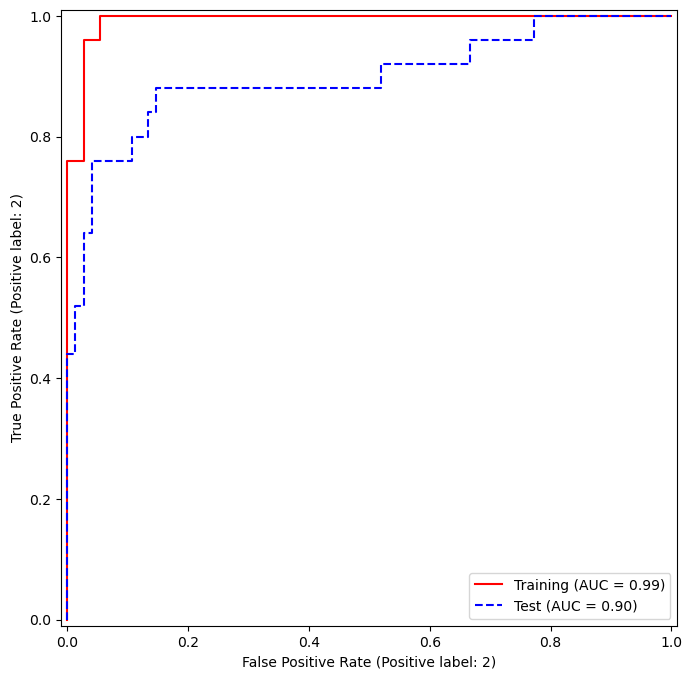

In [22]:
# ROC for the best estimator of SVM with radial basis function in training data
fig, ax = plt.subplots(figsize=(8,8))
roc_curve(bestgrid_rbf05, X_train, y_train, name='Training', color='r', linestyle='-', ax=ax);
roc_curve(bestgrid_rbf05, X_test, y_test, name='Test', color='b', linestyle='--', ax=ax);

- The plot shows that the SVM provides a accurate prediction with an AUC of 0.99.
- We increase $\gamma$ to make the boundary more irregular. This will improve the accuracy.

 In this example, the SVM appears to provide accurate predictions. By increasing
$\gamma$ we can produce a more flexible fit and generate further
improvements in accuracy.

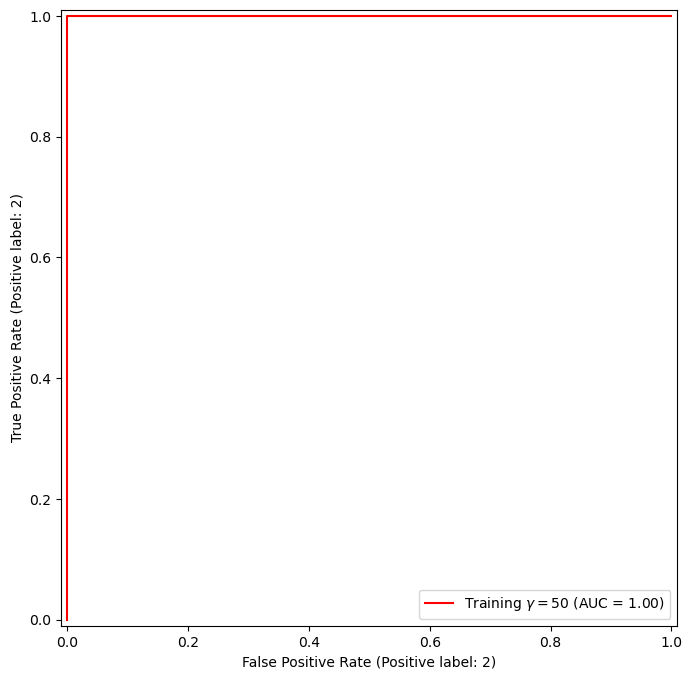

In [23]:
SVM_rbfG50 = SVC(kernel="rbf", gamma=50, C=1).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(8,8))
roc_curve(SVM_rbfG50, X_train, y_train,
          name=r'Training $\gamma=50$',
          color='r', ax=ax);

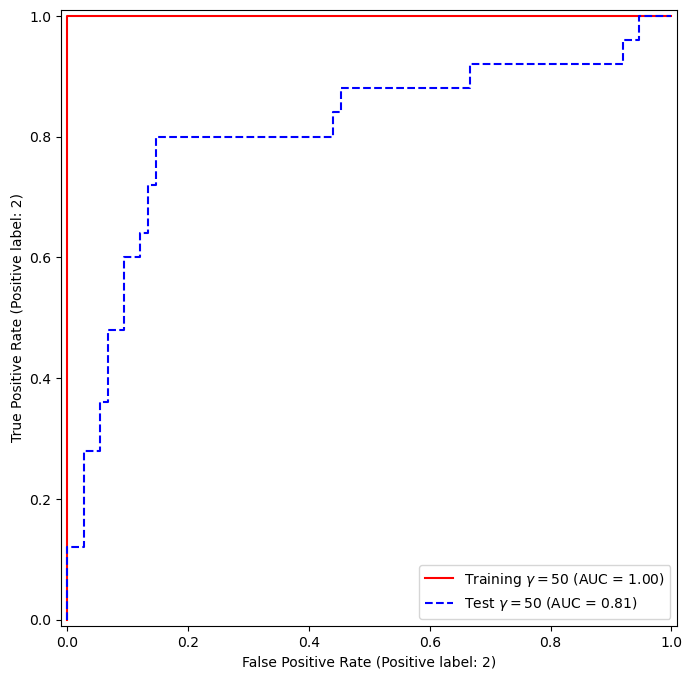

In [24]:
# ROC for gamma=50
roc_curve(SVM_rbfG50, X_test, y_test, name=r'Test $\gamma=50$', color='b', linestyle='--', ax=ax)
fig

- We redo SVM for gamma=0.5 and plot them together.

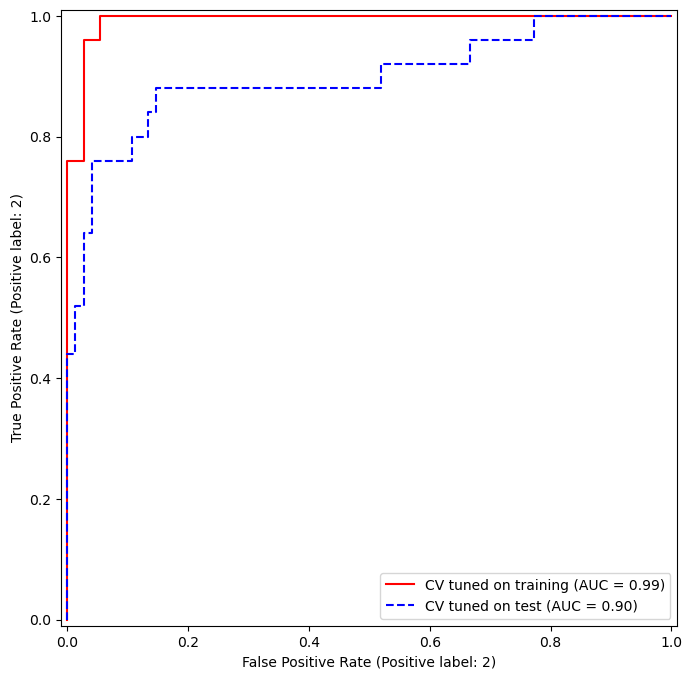

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
for (X_, y_, c, name, lt) in zip( (X_train, X_test), (y_train, y_test), 
    ('r', 'b'), ('CV tuned on training', 'CV tuned on test'), ('-', '--') ):
    roc_curve(bestgrid_rbf05, X_, y_, name=name, ax=ax, color=c, linestyle=lt)

- The plot shows that the SVM with gamma=0.5 provides a better prediction than the SVM with gamma=50.

# SVM with Multiple Classes
- We still use `SupportVectorMachine()` (`SVC`) from `sklearn.svm` to handle multiple classes.
- `SVC` will perform one-vs-one classification when `decision_function_shape='ovo'` or one-vs-rest classification when `decision_function_shape='ovr'`.



If the response is a factor containing more than two levels, then the
`SVC()`  function will perform multi-class classification using
either the one-versus-one approach (when `decision_function_shape=='ovo'`)
or one-versus-rest {One-versus-rest is also known as one-versus-all.} (when `decision_function_shape=='ovr'`).
We explore that setting briefly here by
generating a third class of observations.

In [ ]:
np.hstack([y, [0]*50])

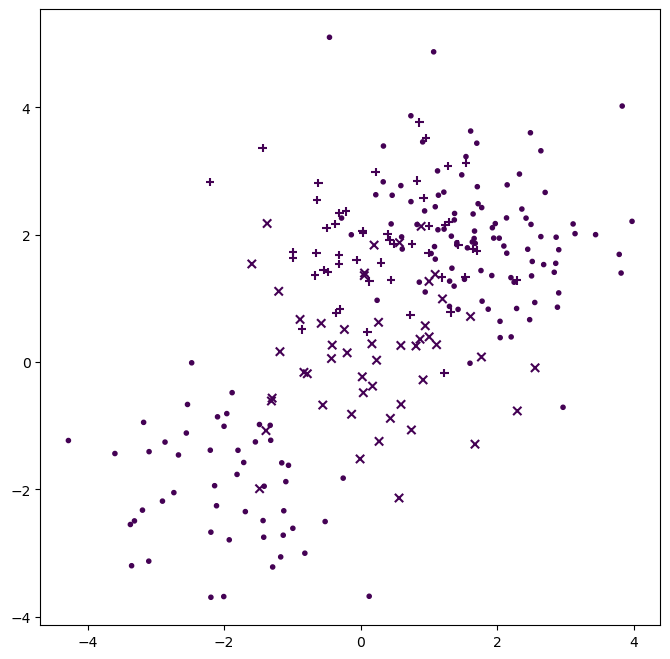

In [28]:
# Generate data with 3 classes
rng = np.random.default_rng(123)
# Add the third class data (shape 50x2) to the previous data
X = np.vstack([X, rng.standard_normal((50, 2))])
# Add the third class y values to the previous y values
y = np.hstack([y, [0]*50])
# Select the rows of first and third class data and add 2 to each element
X[y==0,1] += 2
# Create a scatter plot of the data
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:150,0], X[:150,1], c=y[:150], marker='.')
ax.scatter(X[150:200,0], X[150:200,1], c=y[150:200], marker='x');
ax.scatter(X[200:,0], X[200:,1], c=y[200:], marker='+');

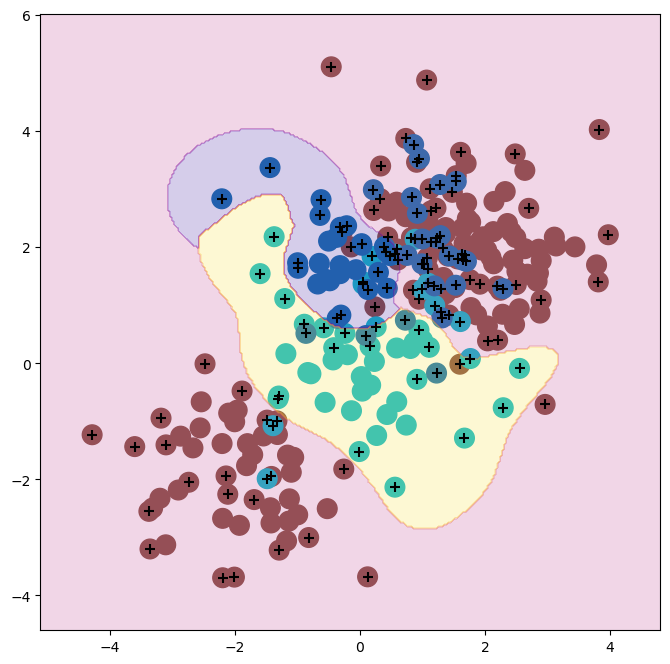

In [29]:
# Set and fit a radial basis function SVM
svm_rbf_3 = SVC(kernel="rbf", C=10, gamma=1,
                decision_function_shape='ovo');
svm_rbf_3.fit(X, y)
# Plot the decision boundary
fig, ax = plt.subplots(figsize=(8,8))
plot_svm(X, y, svm_rbf_3, scatter_cmap=plt.cm.tab10, ax=ax);

- `sklearn.svm` package can also be used to perform support vector regression with a numerical response using the  estimator `SupportVectorRegression()`.

# Application to Gene Expression Data
## The `Khan` Data Set
- It consists of a number of tissue samples corresponding to four distinct types of small round blue cell tumors.
    - A tissue sample is a small piece of tissue taken from the body to be examined under a microscope. This is often done to diagnose diseases, including cancer, by analyzing the cells and structures within the tissue.
    - A small round blue cell tumor is a type of cancer that is made up of small, round cells that look blue under the microscope.
- For each tissue sample, gene expression measurements are available.
- The data set consists of training data, `xtrain` and `ytrain`, and testing data, `xtest` and `ytest.

In [ ]:
Khan = load_data('Khan')
Khan['xtrain'].head(3)

In [ ]:
Khan['xtest'].head(3)

In [ ]:
Khan['ytrain'].head(3)

In [ ]:
Khan['xtrain'].describe()

In [ ]:
print('Shape of xtrain:', Khan['xtrain'].shape)
print('Shape of xtest:', Khan['xtest'].shape)

- The data set consists of expression measurements for 2308 genes.
- The training data set consists of 63 observations.
- The test data set consists of 20 observations.
- Because the number of features (genes) is much larger than the number of observations, we should use a linear kernel.

In [ ]:
# Set and fit a linear SVM on the training data
khan_linear = SVC(kernel='linear', C=10)
khan_linear.fit(Khan['xtrain'], Khan['ytrain'])
# Create a confusion table
confusion_table(khan_linear.predict(Khan['xtrain']),
                Khan['ytrain'])

- The result shows that there **no** training errors.
- It is not surprising, because the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate the classes.
- We perform the support vector classifier on the test observations.

In [ ]:
confusion_table(khan_linear.predict(Khan['xtest']),
                Khan['ytest'])
